In [1]:
import itertools
import numpy as np 

In [2]:
from setupPOMDP import *
from visualizeEnvironment import *

In [23]:
class SetupEpsilonTransitionWithBarrier(object):
    def __init__(self, stateSet, actionSet):
        self.stateSet = stateSet
        self.actionSet = actionSet

    def __call__(self, barrierList, epsilon=0):
        transitionTable = {state: {action:  self.getStateActionTransition(state, action, epsilon, barrierList) \
                                   for action in self.actionSet}\
                           for state in self.stateSet}
        return(transitionTable) 

    
    def getStateActionTransition(self, currentState, action, epsilon, barriers):
        
        nextState = self.getNextState(currentState, action, barriers)
        
        if currentState == nextState or epsilon == 0:
            transitionDistribution = {nextState: 1}
        else:
            transitionDistribution = {nextState: 1-epsilon, currentState:epsilon}
            
        return(transitionDistribution)

    
    def getNextState(self, state, action, barriers):
        potentialNextState = tuple([state[i] + action[i] for i in range(len(state))])
        
        if potentialNextState in self.stateSet and (not [state, potentialNextState] in barriers):
            return(potentialNextState)
        return(state) 

In [20]:
a = [[(1,0), (1,1)], [(2,0), (2,1)]]

In [21]:
[(1,0), (1,1)] in a

True

# Environments

In [3]:
# Actions correspond to E, N, W, S, Stay respectively
allActions = [(1,0), (0,1), (-1,0), (0,-1), (0,0)]

#all location states in grid
gridWidth = 5
gridHeight = 5
gridSet = set(itertools.product(range(gridWidth), range(gridHeight)))

#set of states to remove from each environment
barriersC = {(2,1), (3,1), (4,1)}

#final environment state sets
stateSetC = list(gridSet.difference(barriersC))

#goal locations
goal1 = (0,4)
goal2 = (4,4)

#probability of ineffective action
epsilon = .1

In [4]:
getTransition = SetupEpsilonTransition(epsilon)

# possible environment transitions
environmentC = getTransition(stateSetC, allActions)

In [5]:
"""
Probabilistically draw the next location state given the dynamics of the transition function
Input: transition dictionary, current state tuple, action tuple
Output: next location state tuple
"""
def drawNextState(transitionFunction, state, action):
    nextStates = list(transitionFunction[state][action].keys())
    probabilities = list(transitionFunction[state][action].values())
    nextState = nextStates[np.random.choice(len(nextStates), p=probabilities)]
    return(nextState)

In [6]:
# Example:
drawNextState(environmentC, (0,0), (1,0))

(1, 0)

## Environment C Example

In [7]:
viewDictionaryStructure(environmentC, ["state", "action", "next state", "probability"])

state: (3, 2)
	action: (1, 0)
		next state: (4, 2)
			probability: 0.9
		next state: (3, 2)
			probability: 0.1
	action: (0, 1)
		next state: (3, 3)
			probability: 0.9
		next state: (3, 2)
			probability: 0.1
	action: (-1, 0)
		next state: (2, 2)
			probability: 0.9
		next state: (3, 2)
			probability: 0.1
	action: (0, -1)
		next state: (3, 2)
			probability: 1
	action: (0, 0)
		next state: (3, 2)
			probability: 1
state: (1, 3)
	action: (1, 0)
		next state: (2, 3)
			probability: 0.9
		next state: (1, 3)
			probability: 0.1
	action: (0, 1)
		next state: (1, 4)
			probability: 0.9
		next state: (1, 3)
			probability: 0.1
	action: (-1, 0)
		next state: (0, 3)
			probability: 0.9
		next state: (1, 3)
			probability: 0.1
	action: (0, -1)
		next state: (1, 2)
			probability: 0.9
		next state: (1, 3)
			probability: 0.1
	action: (0, 0)
		next state: (1, 3)
			probability: 1
state: (0, 0)
	action: (1, 0)
		next state: (1, 0)
			probability: 0.9
		next state: (0, 0)
			probability: 0.1
	acti

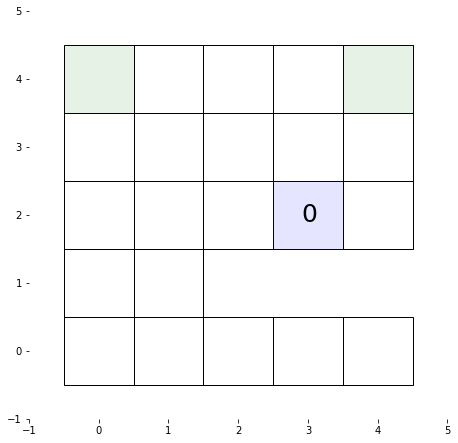

In [8]:
visualizeEnvironment(gridWidth = gridWidth, gridHeight = gridHeight, states = stateSetC, \
                     goalStates = [(0,4, " "), (4,4, " ")], trajectory = [(3,2)])

# Preferences

lists all possible worlds as well as all possible preference rankings among K, L, and M

In [9]:
allWorlds = [(c1, c2) for c1, c2 in itertools.permutations("KLM", 2)]
possibleWorldsInLocation = [{goal1: comb1, goal2: comb2} for comb1, comb2 in itertools.permutations("KLM", 2)]
possiblePreferenceRankings = [rank for rank in itertools.permutations("KLM",3)]

In [10]:
print(allWorlds, "\n")
print(possibleWorldsInLocation, "\n")
print(possiblePreferenceRankings, "\n")

[('K', 'L'), ('K', 'M'), ('L', 'K'), ('L', 'M'), ('M', 'K'), ('M', 'L')] 

[{(0, 4): 'K', (4, 4): 'L'}, {(0, 4): 'K', (4, 4): 'M'}, {(0, 4): 'L', (4, 4): 'K'}, {(0, 4): 'L', (4, 4): 'M'}, {(0, 4): 'M', (4, 4): 'K'}, {(0, 4): 'M', (4, 4): 'L'}] 

[('K', 'L', 'M'), ('K', 'M', 'L'), ('L', 'K', 'M'), ('L', 'M', 'K'), ('M', 'K', 'L'), ('M', 'L', 'K')] 



In [11]:
"""
Construct the input for a reward function.

Inputs: world is a dictionary where keys are the coordinates of goals and the values are the names of those goals
preference is a tuple indicating the relatve ranking of the worth of goals and 
preference rewards is a list of how much reward the rank of each goal should receive

outputs: a dictionary with goal locations as keys and the numerical reward associated with them as the values
"""
def constructPreferences(world, preference, preferenceRewards = [1000, 400, 100]):
    goalPreferences = {location : preferenceRewards[preference.index(truck)] for location, truck in world.items()}
    return(goalPreferences)

In [12]:
#Example
print(constructPreferences({(0,0):'L', (9,4):'K'}, ('M', 'L', 'K')))
print(constructPreferences(possibleWorldsInLocation[2], possiblePreferenceRankings[-1]))

{(0, 0): 400, (9, 4): 100}
{(0, 4): 400, (4, 4): 100}


# Rewards R(s, a, s')

Reward is defined for first, the environment, and second for the relative preferences of the agent. 
We create a reward for each possible world, given that preference relation.

In [13]:
getRewardC = SetupRewardTable(environmentC, allActions)

In [14]:
# example preference of M > K > L, a true world of K in position 0,0 and L in position 9,4
klWorld_mlkPreference = constructPreferences(possibleWorldsInLocation[2], possiblePreferenceRankings[-1])

# example reward function dictionaries for environment C dynamics, Preference M > K > L 
rewards_EnvC_PrefMLK = {tuple(world.values()) : getRewardC(constructPreferences(world, possiblePreferenceRankings[-1])) \
                        for world in possibleWorldsInLocation}

In [15]:
viewDictionaryStructure(rewards_EnvC_PrefMLK[('L', 'K')], levelsReward)

state: (3, 2)
	action: (1, 0)
		next state: (4, 2)
			reward: -1
		next state: (3, 2)
			reward: -1
	action: (0, 1)
		next state: (3, 3)
			reward: -1
		next state: (3, 2)
			reward: -1
	action: (-1, 0)
		next state: (2, 2)
			reward: -1
		next state: (3, 2)
			reward: -1
	action: (0, -1)
		next state: (3, 2)
			reward: -1
	action: (0, 0)
		next state: (3, 2)
			reward: -1
state: (1, 3)
	action: (1, 0)
		next state: (2, 3)
			reward: -1
		next state: (1, 3)
			reward: -1
	action: (0, 1)
		next state: (1, 4)
			reward: -1
		next state: (1, 3)
			reward: -1
	action: (-1, 0)
		next state: (0, 3)
			reward: -1
		next state: (1, 3)
			reward: -1
	action: (0, -1)
		next state: (1, 2)
			reward: -1
		next state: (1, 3)
			reward: -1
	action: (0, 0)
		next state: (1, 3)
			reward: -1
state: (0, 0)
	action: (1, 0)
		next state: (1, 0)
			reward: -1
		next state: (0, 0)
			reward: -1
	action: (0, 1)
		next state: (0, 1)
			reward: -1
		next state: (0, 0)
			reward: -1
	action: (-1, 0)
		next sta

# Belief Rewards Rho(b, s, a, s')

In [16]:
def getBeliefReward(worldBeliefs, worldRewardFunctions, state, action, nextState):
    beliefReward = sum([worldBeliefs[y]*worldRewardFunctions[y][state][action][nextState] for y in worldBeliefs])
    return(beliefReward)

In [17]:
# Example
impartial_b = {world: 1/6 for world in itertools.permutations("KLM", 2)}

In [18]:
getBeliefReward(impartial_b, rewards_EnvC_PrefMLK, (0,0), (0,0), (0,0))

-0.9999999999999999

# Belief Updating: Tau(b, a, b') 

$$ b_t(y) \propto p(o_t|x_t, y, env)b_{t-1}(y)$$

## constructing P(o|x, y)

In [19]:
def createObservations(environment, trueWorldInLocation, stateSet):
    #{world : position state : possible goal: indicator of whether that possible goal is visible in that state/world combo}
    


SyntaxError: unexpected EOF while parsing (<ipython-input-19-000b95b2d561>, line 3)